## Trabalho de Conclusão de disciplina ##
Disciplina: Algoritmos Supervisionados para classificação

Base escolhida: Phone Classification dataset - https://www.kaggle.com/datasets/jacksondivakarr/phone-classification-dataset

A Presente base de dados tem por objetivo a classificação da faixa de preço dos telefones de acordo com diversas características como a bateria, memória RAM, tamanho da tela.
A coluna alvo é a coluna "Price Range".

Para atender aos requesitos do trabalho, foram deixadas apenas 2 faixas de classificação.

### Preparação do Ambiente.
Importando bibliotecas de Interesse

In [1]:
#Importando as bibliotecas de interesse para o Projeto
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

# ignorar warnings
warnings.filterwarnings("ignore")

In [2]:
#Importando o dataset com a biblioteca Pandas
data = pd.read_csv('train.csv', sep=';')
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
2,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
3,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
4,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0


## Análise exploratória

* 1º: Verificar o tipo dos dados da base

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1000 non-null   int64  
 1   blue           1000 non-null   int64  
 2   clock_speed    1000 non-null   float64
 3   dual_sim       1000 non-null   int64  
 4   fc             1000 non-null   int64  
 5   four_g         1000 non-null   int64  
 6   int_memory     1000 non-null   int64  
 7   m_dep          1000 non-null   float64
 8   mobile_wt      1000 non-null   int64  
 9   n_cores        1000 non-null   int64  
 10  pc             1000 non-null   int64  
 11  px_height      1000 non-null   int64  
 12  px_width       1000 non-null   int64  
 13  ram            1000 non-null   int64  
 14  sc_h           1000 non-null   int64  
 15  sc_w           1000 non-null   int64  
 16  talk_time      1000 non-null   int64  
 17  three_g        1000 non-null   int64  
 18  touch_scr

##### Conforme podemos ver acima, temos 13 colunas e 13730 linhas e o tipo predominante é int(64)

* 2º: Há alguma coluna com valor nulo?

In [4]:
# analisando dados nulos
data.isna().any()

battery_power    False
blue             False
clock_speed      False
dual_sim         False
fc               False
four_g           False
int_memory       False
m_dep            False
mobile_wt        False
n_cores          False
pc               False
px_height        False
px_width         False
ram              False
sc_h             False
sc_w             False
talk_time        False
three_g          False
touch_screen     False
wifi             False
price_range      False
dtype: bool

* 3º: Análise do balanceamento da coluna target utilizando value_counts e gráfico de barras

In [5]:
data['price_range'].value_counts(normalize=True)
#Como podemos ver abaixo, os dados estão balanceados.

price_range
1    0.5
0    0.5
Name: proportion, dtype: float64

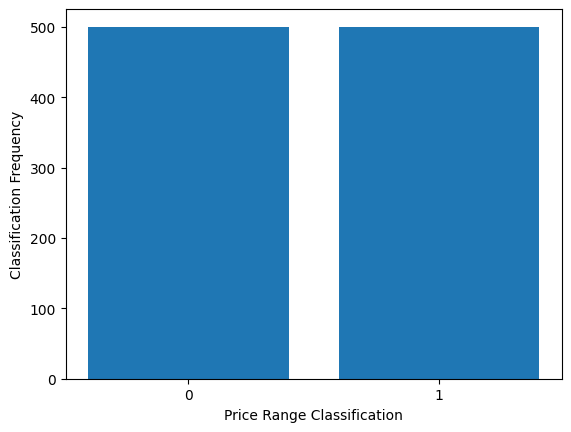

In [6]:
#Verificação gráfica do balancemaneto dos dados. Isto é um passo importante pois, se os dados não estiverem balanceados, o modelo pode ter um viés para uma classe.
plt.bar(data['price_range'].value_counts(normalize=True).index, 
        data['price_range'].value_counts().values)
plt.xticks(data['price_range'].value_counts().index)
plt.xlabel('Price Range Classification')
plt.ylabel('Classification Frequency')
plt.show()

# Matriz de correlação para verificar a correlação entre as variáveis.
- Aqui o objetivo é encontrar uma feature dentro da base de dados que tenha uma boa correlação com o modelo, o que facilitará em muito o processo de classificação

<Axes: >

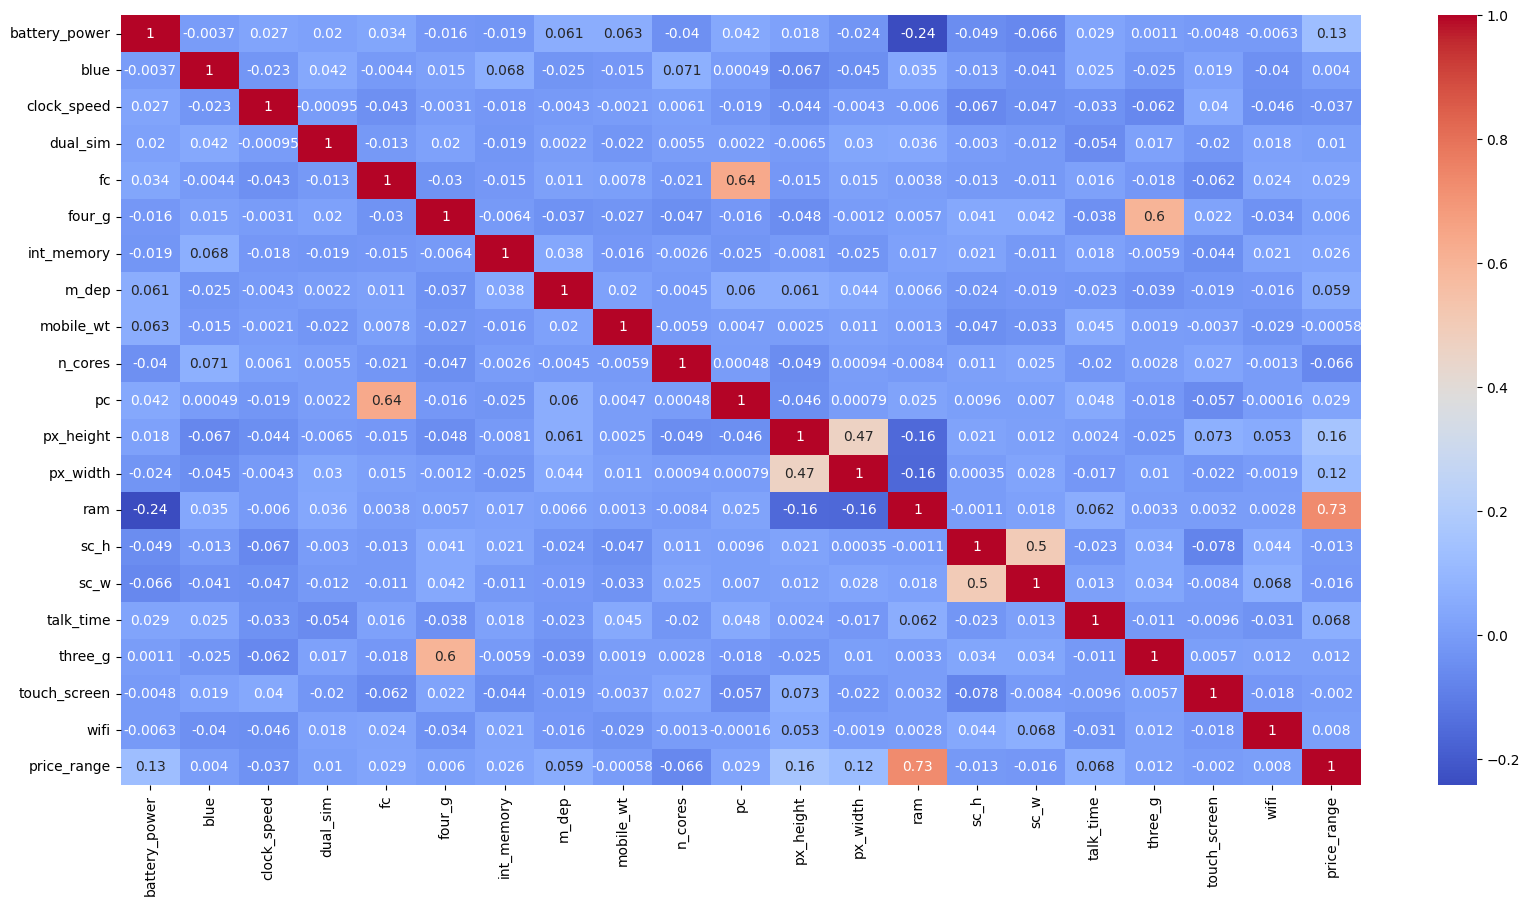

In [7]:
#criar uma matriz de correlação
correlation = data.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

#### É possivel pela matriz acima ver que a coluna target ('price_range') tem uma correlação alta com a memória RAM.

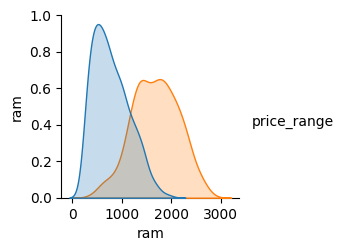

In [8]:
#Agora, verifiquemos de maneira mais clara e gráfica a correlação entre essas duas variáveis
sns.pairplot(data[['price_range', 'ram']], hue='price_range')
plt.show()

#### Conforme podemos ver, a variável RAM tem uma correlação muito forte com a variável target, que é a variável que queremos prever. Isso é um bom sinal, pois indica que a variável RAM pode ser um bom preditor para a variável target.

- Qual a diferença entre uma regressão logistica e regressão linear?

A regressão logística é usada para prever a probabilidade de um evento ocorrer, enquanto a regressão linear é usada para prever o valor de uma variável dependente com base em uma variável independente.

- Descreva as etapas necessárias para criar um modelo de classificação eficiente?

1 - Analise Exploratória da base. Buscar colunas com valores nulos, tipos dos dados, correlação entre as variáveis, busca por uma feature que seja boa para classificar

2 - Determinar a coluna alvo a ser classificada e separar de acordo com isso (x e y)

3 - Separar a base em treino e teste

4 - Configurar um Pipeline para o modelo, onde serão passados um transformador de alguma coluna (caso necessário), um método de escalonamento para os dados e um modelo

5 - Treinar o Pipeline

6 - Fazer previsoes com a base de teste e com a base de treino e medir os resultados utilizando o classification report.


In [9]:
# separando x e y
x = data.drop('price_range', axis=1)
y = data['price_range']

In [10]:
#separando treino e teste
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, stratify=y)

#### Treinando utilizando Regressão Logística

In [11]:
#Como a coluna target do meu dataset não é categórica, eu não preciso fazer um encoding nela.

#Configurando um Pipeline
rl = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(penalty=None, random_state=1))
])

#Treinando o Pipeline
rl.fit(x_train,y_train)


Pipeline(steps=[('scaler', RobustScaler()),
                ('model', LogisticRegression(penalty=None, random_state=1))])

In [12]:
#Fazendo previsões
prev_rl_test = rl.predict(x_test)
prev_rl_train = rl.predict(x_train)

# Analise das métricas
print("DESEMPENHO BASE DE TREINO")
print(classification_report(y_train, prev_rl_train))

print("==============================================================")

print("DESEMPENHO BASE DE TESTE")
print(classification_report(y_test, prev_rl_test))

DESEMPENHO BASE DE TREINO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

DESEMPENHO BASE DE TESTE
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       150
           1       0.98      0.97      0.97       150

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



### Treinando utilizando um modelo de árvore de decisão

In [13]:
#As bases de treino e teste ja estão separadas, logo, não precisamos fazer a separação novamente.

#Configurando um Pipeline de Arvore de Decisão
dt_pipe = DecisionTreeClassifier(random_state=1)

#Treinando o Pipeline
dt_pipe.fit(x_train,y_train)

DecisionTreeClassifier(random_state=1)

In [14]:
#Fazendo previsões
prev_dt_test = dt_pipe.predict(x_test)
prev_dt_train = dt_pipe.predict(x_train)

# Analise das métricas
print("DESEMPENHO BASE DE TREINO")
print(classification_report(y_train, prev_dt_train))

print("==============================================================")

print("DESEMPENHO BASE DE TESTE")
print(classification_report(y_test, prev_dt_test))

DESEMPENHO BASE DE TREINO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

DESEMPENHO BASE DE TESTE
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       150
           1       0.89      0.92      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



- Pela base acima, podemos ver que o modelo de Arvore de Decisão está com *overfitting*, pois o desempenho na base de treino é muito superior ao desempenho na base de teste.


Agora utilizaremos o buscador de hiperparâmetros para encontrar o melhor conjuntos de hiperparâmetros que melhore o desempenho do modelo

In [15]:
# analisando as dimensões desse primeiro modelo
print(f'Número de atributos: {x_train.shape[1]}')
print(f'Profundidade da Árvore: {dt_pipe.get_depth()}')
print(f'Número de folhas da árvore: {dt_pipe.get_n_leaves()}')

Número de atributos: 20
Profundidade da Árvore: 10
Número de folhas da árvore: 46


In [16]:
#Utilizando o RandomizedSearchCV para encontrar os melhores hiperparâmetros
#Configurando o Pipeline
dt_pipe_2 = Pipeline([
    ('model', DecisionTreeClassifier(random_state=1))
])

#Configurando o Grid de Hiperparâmetros
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': range(1, 7),
}

#Configurando um amostrador aleatório
splitter = StratifiedKFold(10, shuffle=True, random_state=1)

#Configurando o RandomizedSearchCV
gs_dt = RandomizedSearchCV(
    dt_pipe_2, 
    param_distributions=param_grid, 
    cv=splitter,
    refit=True,
    verbose=10,
    scoring='precision' ,
    error_score=0
    )


In [17]:
# realizar a busca dos hiperparâmetros
gs_dt.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__criterion=gini, model__max_depth=6.................
[CV 1/10; 1/10] END model__criterion=gini, model__max_depth=6;, score=0.944 total time=   0.0s
[CV 2/10; 1/10] START model__criterion=gini, model__max_depth=6.................
[CV 2/10; 1/10] END model__criterion=gini, model__max_depth=6;, score=0.829 total time=   0.0s
[CV 3/10; 1/10] START model__criterion=gini, model__max_depth=6.................
[CV 3/10; 1/10] END model__criterion=gini, model__max_depth=6;, score=0.857 total time=   0.0s
[CV 4/10; 1/10] START model__criterion=gini, model__max_depth=6.................
[CV 4/10; 1/10] END model__criterion=gini, model__max_depth=6;, score=0.938 total time=   0.0s
[CV 5/10; 1/10] START model__criterion=gini, model__max_depth=6.................
[CV 5/10; 1/10] END model__criterion=gini, model__max_depth=6;, score=0.971 total time=   0.0s
[CV 6/10; 1/10] START model__criterion=gini, model__max_d

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('model',
                                              DecisionTreeClassifier(random_state=1))]),
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': range(1, 7)},
                   scoring='precision', verbose=10)

In [18]:
print("Melhor combinação de parâmetros")
print(gs_dt.best_params_)

print("==============================================================")
print("Melhor desempenho médio")
print(gs_dt.best_score_)

Melhor combinação de parâmetros
{'model__max_depth': 6, 'model__criterion': 'log_loss'}
Melhor desempenho médio
0.9127519303368825


In [19]:
# analisando o desempenho final
# realizando novas previsões
gs_dt_train = gs_dt.best_estimator_.predict(x_train)
gs_dt_test = gs_dt.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, gs_dt_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, gs_dt_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       350
           1       0.98      0.97      0.98       350

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       150
           1       0.89      0.95      0.92       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



* Com a utilização do buscador de hiperparâmetros, conseguimos melhorar o desempenho do modelo em comparação ao uso da árvore de decisão sem o buscador de hiperparâmetros.

### Treinando utilizando um modelo de SVM

In [20]:
# criando um pipeline de modelagem
svc = Pipeline([
    ('scaler', RobustScaler()),
    ('SVC', SVC(random_state=2))
])

# TREINAR O PIPELINE
svc.fit(x_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('SVC', SVC(random_state=2))])

In [21]:
# realizar novas previsoes
svc_train = svc.predict(x_train)
svc_test = svc.predict(x_test)

In [22]:
# analise do desempenho - base de treino
print('Desempenho na base de treino')
print(classification_report(y_train, svc_train))

# analise do desempenho - base de teste
print('Desempenho na base de teste')
print(classification_report(y_test, svc_test))

Desempenho na base de treino
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       350
           1       0.99      0.99      0.99       350

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Desempenho na base de teste
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       150
           1       0.93      0.96      0.94       150

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



Podemos ver acima que o modelo está com overfitting. Utilizaremos agora o Kernel SVM para ver se conseguimos melhorar os dados.

In [27]:
#Pipelined eModelagem
ksvc = Pipeline([
    ('scaler', RobustScaler()),
    ('ksvc', SVC(random_state=2))
])

#configurar o espaço de busca
ksvc_params = {
    'ksvc__kernel':['rbf', 'linear', 'sigmoid', 'cosine', 'poly'],
    'ksvc__C' : np.random.uniform(1,100,50),
    'ksvc__gamma':np.random.uniform(0.01,10,100)
}

# configurar um amostrador (Stratified K Fold)
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# configura um buscador aleatório
krs = RandomizedSearchCV(
    estimator=ksvc,
    param_distributions=ksvc_params,
    n_iter=200,
    scoring='precision',
    cv=kfold_cv,
    refit=True,
    error_score=0,
    verbose=10
)

# realizando busca aleatória
krs.fit(x_train, y_train)


Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV 1/10; 1/200] START ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf
[CV 1/10; 1/200] END ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf;, score=0.795 total time=   0.0s
[CV 2/10; 1/200] START ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf
[CV 2/10; 1/200] END ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf;, score=0.604 total time=   0.0s
[CV 3/10; 1/200] START ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf
[CV 3/10; 1/200] END ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf;, score=0.732 total time=   0.0s
[CV 4/10; 1/200] START ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf
[CV 4/10; 1/200] END ksvc__C=91.62985181272936, ksvc__gamma=1.3775376991770232, ksvc__kernel=rbf;, score=0.673 total time=   0.0s
[CV 5/10; 1/200] ST

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('ksvc', SVC(random_state=2))]),
                   n_iter=200,
                   param_distributions={'ksvc__C': array([83.10526569, 73.79136234, 69.19360404,  6.30091847,  7.35546741,
       44.51571993, 90.71263301, 67.1649157 , 91.62985181, 31.34383287,
       51.68854...
       7.38732582, 2.859472  , 6.40611695, 7.37467657, 1.43165681,
       3.97234369, 6.65029439, 7.01647942, 2.11001922, 1.36110251,
       7.2565414 , 2.21113278, 1.67846067, 6.05730292, 9.65165636,
       5.2939924 , 9.9939359 , 3.43802061, 8.29288675, 3.65386574,
       2.57560917, 9.00989736, 9.50893781, 9.96984366, 2.86923733]),
                                        'ksvc__kernel': ['rbf', 'linear',
                                                         'sigmoid', 'cosine',
                                                         'poly']},
                   scoring='precision', verbose=10)

In [28]:
#O melhor modelo encontrado
print("Melhor combinação de parâmetros")
print(krs.best_params_)
print("==============================================================")
print("Melhor desempenho médio")
print(krs.best_score_)
print("==============================================================")


Melhor combinação de parâmetros
{'ksvc__kernel': 'linear', 'ksvc__gamma': 7.25654140136021, 'ksvc__C': 14.398656286294102}
Melhor desempenho médio
0.983935508935509


In [29]:
# analisando o desempenho final
# realizando novas previsões
krsvc_train_ksvc = krs.best_estimator_.predict(x_train)
krscv_test_ksvc = krs.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, krsvc_train_ksvc))

print('Desempenho - Base de Teste')
print(classification_report(y_test, krscv_test_ksvc))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       350
           1       1.00      0.98      0.99       350

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       150
           1       0.98      0.99      0.99       150

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



## Qual o modelo a ser escolhido?

R: O melhor modelo a ser escolhido é o SVM Kernel. Utilizando o SVM em um primeiro momento observamos que o modelo estava com muito *overfitting*. Após aplicação do tunning dos hiperparâmetros foi possível a chegar a um conjunto de métricas que melhorou significativamente os resultados na base de teste.

Por mais que o modelo de Regressão Logísitca consiga também um bom desempenho, há um leve overfitting na base o que prejudica eventuais generalizações a serem feitas, pois o modelo ficou extremamente rígido.